<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Targeted_HopSkipJumpAttack_using_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Image Visualization</b>

* Resize the displayed image to be large enough.

In [ ]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [ ]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

#### <b>Load Pre-trained Classification Model</b>

* <b>The attack target model</b>: ResNet-18
* <b>Dataset</b>: CIFAR-10

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcpGMF03mR9Ko1MM-kMSmloB4ceabuYCvnHaGZPgLNMzrA?download=1 -O cifar10_model.pth

--2021-03-12 10:12:35--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcpGMF03mR9Ko1MM-kMSmloB4ceabuYCvnHaGZPgLNMzrA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/Pytorch%20Adversarial%20Training%20on%20CIFAR-10/Pre-trained/basic_training?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FY3BHTUYwM21SOUtvMU1NLWtNU21sb0I0Y2VhYnVZQ3ZuSGFHWlBnTE5NenJBP3J0aW1lPXdpMS1YRF9sMkVn [following]
--2021-03-12 10:12:37--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/Pytorch%20Adversarial%20Training%20on%20CIFAR-10/Pre-trained/basic_training?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGF

In [ ]:
# Define a basic block for the ResNet architecture
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # residual connection
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# (The number of layers that contain trainable weights == 18)
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
model = ResNet18()
model = model.to(device)
model = torch.nn.DataParallel(model)
checkpoint = torch.load('./cifar10_model.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

#### <b>Load Test Dataset</b>

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


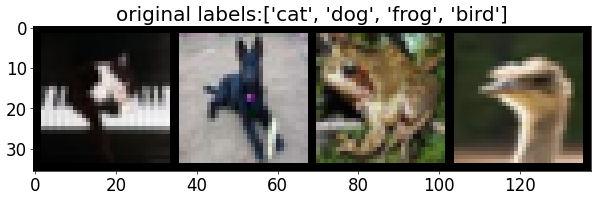

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #2: dog (5)
Image #3: frog (6)
Image #4: bird (2)


In [ ]:
import numpy as np


# Display images in a batch
def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

# load a batch of validation image
iterator = iter(test_dataloader)

# visualize a batch of validation image (the first 4 images)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels: ' + str([class_names[x] for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, label in enumerate(classes[:4]):
    print(f'Image #{i + 1}: {class_names[label]} ({label})')

#### <b>Test Phase</b>

* Check the test accuracy of the pre-trained classification model.

[Prediction Result Examples]


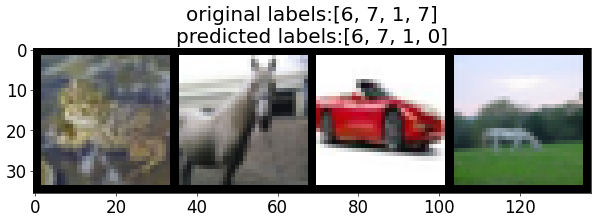

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: horse (7)
Image #1: automobile (1)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: horse (7)
Image #1: automobile (1)
Image #1: airplane (0)


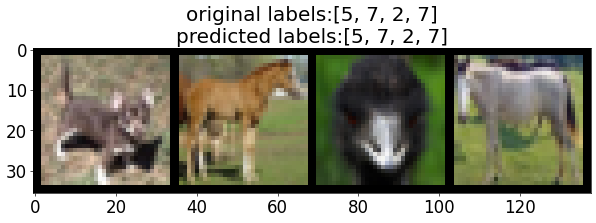

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: horse (7)
Image #1: bird (2)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: horse (7)
Image #1: bird (2)
Image #1: horse (7)
[Validation] Loss: 0.0033 Accuracy: 95.2800% Time elapsed: 6.8521s (total 10000 images)


In [ ]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            # Display the first 4 images in the first batch.
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels: ' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{j + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{j + 1}: {class_names[label]} ({label})')

            # Display the second 4 images in the first batch.
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels: ' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{j + 5}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{j + 5}: {class_names[label]} ({label})')

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [ ]:
!pip install foolbox
!pip install advertorch

In [ ]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>HopSkipJumpAttack</b>

* <b>Foolbox documentation</b>: https://foolbox.readthedocs.io/en/stable/
* <b>HopSkipJumpAttack implementation</b>: [HopSkipJumpAttack](https://github.com/bethgelab/foolbox/blob/master/foolbox/attacks/hop_skip_jump.py)
* <b>init_attack</b>: Attack to use to find starting points.
    * The targeted attack does not use this parameter.
    * The untargeted attack can use a random uniform noise.
* <b>steps</b>: Number of optimization steps.
* <b>initial_gradient_eval_steps</b>: Initial number of evaluations for gradient estimation.
* <b>max_gradient_eval_steps</b>: Maximum number of evaluations for gradient estimation.
* <b>stepsize_search</b>: "geometric_progression" or "grid_search".
* <b>gamma</b>: It's for the binary search threshold.
* <b>constraint</b>: Norm to minimize, either "l2" or "linf".

<pre>
def __init__(
    self,
    init_attack: Optional[MinimizationAttack] = None,
    steps: int = 64,
    initial_gradient_eval_steps: int = 100,
    max_gradient_eval_steps: int = 10000,
    stepsize_search: Union[
        Literal["geometric_progression"], Literal["grid_search"]
    ] = "geometric_progression",
    gamma: float = 1.0,
    tensorboard: Union[Literal[False], None, str] = False,
    constraint: Union[Literal["linf"], Literal["l2"]] = "l2",
):
</pre>

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Options</b>: 10 iterations + start from the target (targeted attack)
    * Each iteration includes a binary search step, gradient approximation step, and geometric progression step.
* <b>Images</b>: 1,000 test images

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


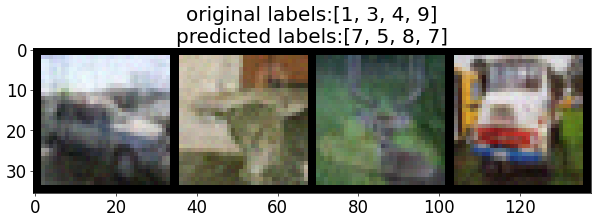

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: cat (3)
Image #1: deer (4)
Image #1: truck (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: horse (7)
Image #1: dog (5)
Image #1: ship (8)
Image #1: horse (7)


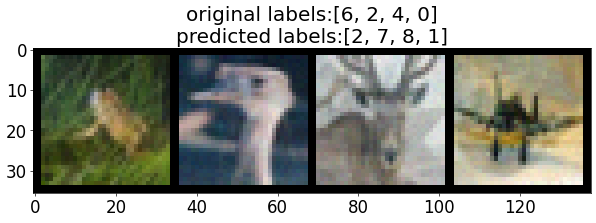

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: bird (2)
Image #1: deer (4)
Image #1: airplane (0)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: horse (7)
Image #1: ship (8)
Image #1: automobile (1)
[Step #0] Loss: 0.0182 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 49.2707s (total 64 images)
[Step #10] Loss: 0.0172 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 531.2170s (total 704 images)
[Validation] Loss: 0.0174 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 771.6314s (total 1024 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 3065.546875
Average L2 distance: 3.326210394501686
Average MSE: 0.0040247627039207146
Average Linf distance (the maximum changed values): 0.16626308299601078


In [ ]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=10,
                                initial_gradient_eval_steps=100, max_gradient_eval_steps=100)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 1000

for i, (inputs, labels) in enumerate(test_dataloader):
    num_images -= labels.shape[0]

    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 32, 32).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        # Display the first 4 images in the first batch.
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')

        # Display the second 4 images in the first batch.
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Options</b>: 30 iterations + start from the target (targeted attack)
    * Each iteration includes a binary search step, gradient approximation step, and geometric progression step.
* <b>Images</b>: 1,000 test images

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


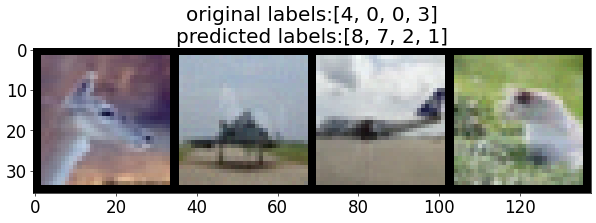

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: airplane (0)
Image #1: airplane (0)
Image #1: cat (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ship (8)
Image #1: horse (7)
Image #1: bird (2)
Image #1: automobile (1)


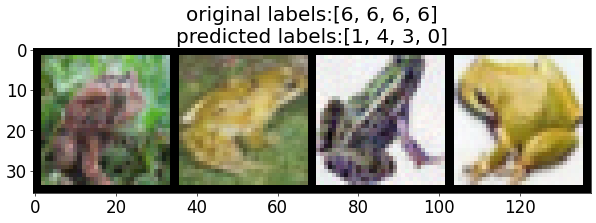

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: frog (6)
Image #1: frog (6)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: deer (4)
Image #1: cat (3)
Image #1: airplane (0)
[Step #0] Loss: 0.0155 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 140.9289s (total 64 images)
[Step #10] Loss: 0.0160 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1573.8732s (total 704 images)
[Validation] Loss: 0.0163 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2286.0712s (total 1024 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 3059.7041015625
Average L2 distance: 1.7888274788856506
Average MSE: 0.0011526371890795417
Average Linf distance (the maximum changed values): 0.09304240718483925


In [ ]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=30,
                                initial_gradient_eval_steps=100, max_gradient_eval_steps=100)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 1000

for i, (inputs, labels) in enumerate(test_dataloader):
    num_images -= labels.shape[0]

    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 32, 32).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        # Display the first 4 images in the first batch.
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')

        # Display the second 4 images in the first batch.
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: HopSkipJump Attack
* <b>Options</b>: 50 iterations + start from the target (targeted attack)
    * Each iteration includes a binary search step, gradient approximation step, and geometric progression step.
* <b>Images</b>: 1,000 test images

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


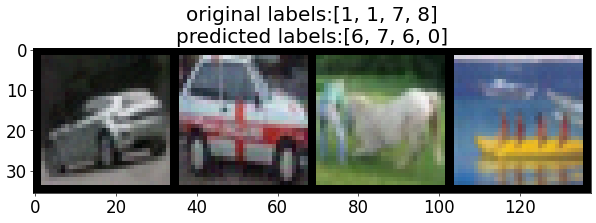

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: automobile (1)
Image #1: horse (7)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: horse (7)
Image #1: frog (6)
Image #1: airplane (0)


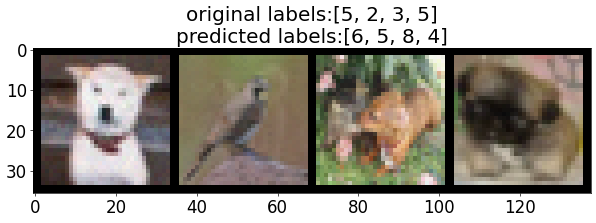

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: bird (2)
Image #1: cat (3)
Image #1: dog (5)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: dog (5)
Image #1: ship (8)
Image #1: deer (4)
[Step #0] Loss: 0.0156 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 241.9456s (total 64 images)
[Step #10] Loss: 0.0161 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2618.0768s (total 704 images)
[Validation] Loss: 0.0160 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3793.4481s (total 1024 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 3059.6591796875
Average L2 distance: 1.319286286830902
Average MSE: 0.0006299173182924278
Average Linf distance (the maximum changed values): 0.0706325676292181


In [ ]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, steps=50,
                                initial_gradient_eval_steps=100, max_gradient_eval_steps=100)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 1000

for i, (inputs, labels) in enumerate(test_dataloader):
    num_images -= labels.shape[0]

    inputs = inputs.to(device)
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 32, 32).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        # Display the first 4 images in the first batch.
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{j + 1}: {class_names[label]} ({label})')

        # Display the second 4 images in the first batch.
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels: ' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels: ' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{j + 5}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)